In [ ]:
#LIBRERIAS----
libraries <- c("tidyverse",
               "readr", 
               "srvyr",
               "ggplot2",
               "showtext", 
               "modeest", 
               "foreign", 
               "haven", 
               "utils", 
               "forecast")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)}

lapply(libraries, library, character.only = TRUE)

In [2]:
#CONSIDERACIONES----
#Tiempo en linea
options(timeout = 8000)
# Fuente
font_add_google(name = "Roboto", family = "Roboto")
showtext_auto()
#Ajustes para las UPM
options(survey.lonely.psu = "certainty")  

**Porcentaje de ingreso destinado al gasto en transporte público**

In [3]:
#ENCUESTA DE INGRESO Y GASTO EN LOS HOGARES----
#Función para leer los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 
leer_enigh <- function(anio)
{ 
  #URL de descarga los datos para los años 2018, 2020 y 2022
  urls <- list("2016" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2016/microdatos/enigh2016_ns_concentradohogar_csv.zip",
               "2018" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2018/microdatos/enigh2018_ns_concentradohogar_csv.zip",
               "2020" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2020/microdatos/enigh2020_ns_concentradohogar_csv.zip",
               "2022" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2022/microdatos/enigh2022_ns_concentradohogar_csv.zip"
  )
  
  # Archivo y directorio temporales
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  # Descargar y descomprimir
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  # Buscar el archivo de datos
  enigh_datos <- list.files(temp_dir, pattern = "concentradohogar.csv", 
                                full.names = TRUE, recursive = TRUE)
  
  # Leer el archivo como caracteres por defecto
  datos <- read_csv(enigh_datos, col_types = NULL)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}


In [ ]:
#ENCUESTA
e2016<-leer_enigh(2016)
e2018<-leer_enigh(2018)
e2020<-leer_enigh(2020)
e2022<-leer_enigh(2022)

In [5]:
#PORCENTAJE DE HOGARES DE DECILES MÁS BAJOS, QUE DESTINAN MÁS DEL 10% DE SU INGRESO AL TRANSPORTE PÚBLICO----
decil_201610 <- e2016|>
  mutate(cve_ent = substr(folioviv, 1, 2), 
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "Más del 10", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))

decil_201810 <- e2018|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "Más del 10", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))


decil_202010 <- e2020|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "Más del 10", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))

decil_202210 <- e2022|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "Más del 10", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))


In [6]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("decil_", anio,"10"))
  
  as_survey_design(objeto_datos,
                   strata = est_dis,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}

In [7]:
dm_2016 <- diseño_muestral(2016)
dm_2018 <- diseño_muestral(2018)
dm_2020 <- diseño_muestral(2020)
dm_2022 <- diseño_muestral(2022)

In [34]:
##PORCENTAJE DE HOGARES DE DECILES MÁS BAJOS QUE DESTINAN EL 10% O MÁS
prc_ingresos_2016 <- dm_2016 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "Más del 10")|>
  mutate(año = 2016)

prc_ingresos_2018 <- dm_2018 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "Más del 10")|>
  mutate(año = 2018)

prc_ingresos_2020 <- dm_2020 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "Más del 10")|>
  mutate(año = 2020)

prc_ingresos_2022 <- dm_2022 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "Más del 10")|>
  mutate(año = 2022)

prc_gasto_tp <- prc_ingresos_2016|>
  bind_rows(prc_ingresos_2018, prc_ingresos_2020, prc_ingresos_2022)|>
  select(año,porcentaje)|>
  mutate(tipo = "Porcentaje de hogares")

prc_gasto_tp

año,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,25.29116,Porcentaje de hogares
2018,25.49381,Porcentaje de hogares
2020,16.86431,Porcentaje de hogares
2022,18.20074,Porcentaje de hogares


In [61]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Método incremental
# https://www.coneval.org.mx/InformesPublicaciones/Documents/Guia_lineas_base_metas.pdf
prc_gasto_tp <- prc_gasto_tp |>
  mutate(valor_lag = lag(porcentaje),
         delta = (porcentaje / valor_lag) - 1)

delta_prom <- mean(prc_gasto_tp$delta, na.rm = TRUE)

delta_prom

# Valor base 2022
valor_2022 <- prc_gasto_tp|>
  filter(año == 2022)|>
  pull(porcentaje)

# Años a proyectar
anios_proy <- c(2030, 2035, 2045)
n_periodos <- anios_proy - 2022

# Proyecciones (tendencia base)
proyeccion_base <- data.frame(año = anios_proy,
                              porcentaje = valor_2022 * ((1 + delta_prom) ^ n_periodos))|>
  mutate(tipo = "Tendencia base")

# Proyección deseable
delta_deseable <- -0.2  # tasa de reducción anual del 6%

proyeccion_deseable <- data.frame(año = anios_proy,
                                  porcentaje = valor_2022 * ((1 + delta_deseable) ^ n_periodos))|>
  mutate(tipo = "Tendencia deseable")

gasto_tp_hogares <- bind_rows(prc_gasto_tp,
                              proyeccion_base,
                              proyeccion_deseable)
                            



[1] -0.0837452

In [62]:
gasto_tp_hogares

año,porcentaje,tipo,valor_lag,delta
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2016,25.2911640,Porcentaje de hogares,NA,NA
2018,25.4938109,Porcentaje de hogares,25.29116,0.008012556
2020,16.8643092,Porcentaje de hogares,25.49381,-0.338493989
2022,18.2007353,Porcentaje de hogares,16.86431,0.079245826
2030,9.0410532,Tendencia base,NA,NA
2035,5.8384872,Tendencia base,NA,NA
2045,2.4347981,Tendencia base,NA,NA
2030,3.0535767,Tendencia deseable,NA,NA
2035,1.0005960,Tendencia deseable,NA,NA


In [63]:
lineas <- bind_rows(data.frame(año = c(2022, 2030),
                               porcentaje = c(gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2022 & gasto_tp_hogares$tipo == "Porcentaje de hogares"],
                                              gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2030 & gasto_tp_hogares$tipo == "Tendencia base"]),
                               tipo = "Tendencia base"),
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2022 & gasto_tp_hogares$tipo == "Porcentaje de hogares"], 
                                              gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2030 & gasto_tp_hogares$tipo == "Tendencia deseable"]),
                               tipo = "Tendencia deseable"))


In [64]:
paleta_colores <- c("Porcentaje de hogares" = "#9F2241",
                    "Tendencia base" = "#027A35",
                    "Tendencia deseable" = "#cfcfcf")

linetypes <- c("Porcentaje de hogares" = "solid",
               "Tendencia base" = "dotdash",
               "Tendencia deseable" = "dotdash")

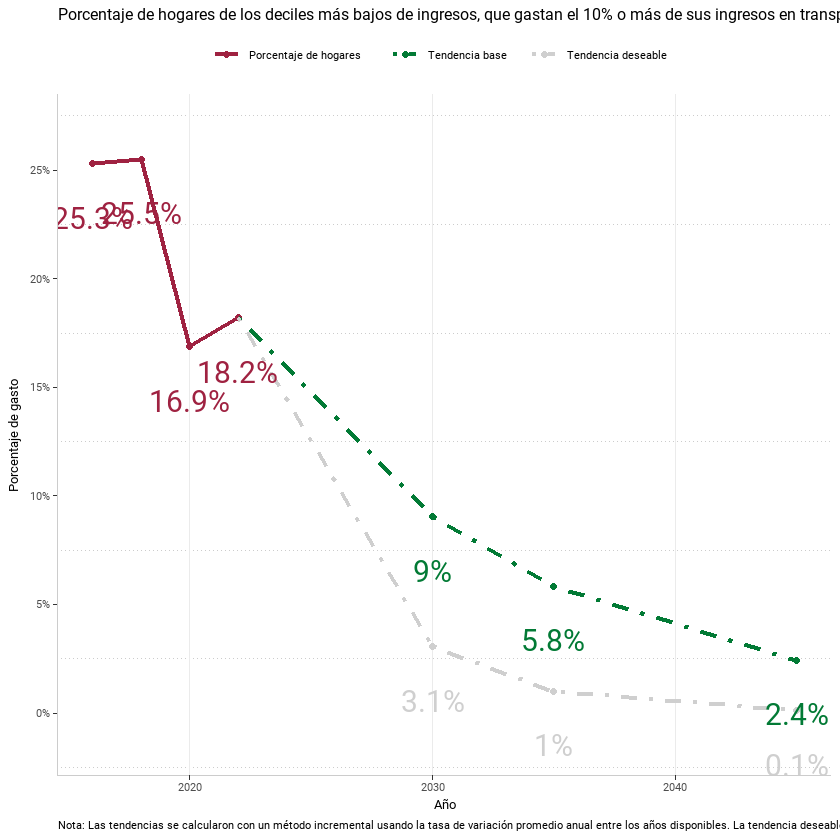

In [84]:
# Gráfico
ggplot(gasto_tp_hogares, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = 3, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(
    breaks = seq(0, ceiling(max(gasto_tp_hogares$porcentaje, na.rm = TRUE) / 5) * 5, by = 5),
    labels = function(x) paste0(x, "%"),
    expand = c(0, 3) 
  ) +
  labs(
    title = "Porcentaje de hogares de los deciles más bajos de ingresos, que gastan el 10% o más de sus ingresos en transporte público",
    x = "Año",
    y = "Porcentaje de gasto",
    color = "",
    linetype = "",
    caption = "Nota: Las tendencias se calcularon con un método incremental usando la tasa de variación promedio anual entre los años disponibles. La tendencia deseable considera una reducción acelerada del indicador."
  ) +
  theme_bw(base_size = 10, base_family = "Roboto") +
  theme(
    panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
    panel.grid.minor.x = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color = "gray80"),
    legend.position = "top",
    plot.caption = element_text(hjust = 0)
  )

ggsave("gasto_tp_hogares.png", width = 12, height = 6, dpi = 300, units = "in")

**Porcentaje de hogares que usan transporte público como principal medio de transporte**


In [ ]:
##DATOS DE GASTOS PERSONA
##Función para leer los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) GASTOSPERSONA----
leer_enigh <- function(anio)
{ 
  #URL de descarga los datos para los años 2018, 2020 y 2022
  urls <- list("2016" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2016/microdatos/enigh2016_ns_gastospersona_csv.zip",
               "2018" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2018/microdatos/enigh2018_ns_gastospersona_csv.zip",
               "2020" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2020/microdatos/enigh2020_ns_gastospersona_csv.zip",
               "2022" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2022/microdatos/enigh2022_ns_gastospersona_csv.zip"
  )
  
  # Archivo y directorio temporales
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  # Descargar y descomprimir
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  # Buscar el archivo de datos
  enigh_datos <- list.files(temp_dir, pattern = "gastospersona.csv", 
                            full.names = TRUE, recursive = TRUE)
  
  # Leer el archivo como caracteres por defecto
  datos <- read_csv(enigh_datos, col_types = NULL)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}

In [ ]:
#CARGAR ENCUESTA GASTOSPERSONA
gastoper2016<-leer_enigh(2016)
gastoper2018<-leer_enigh(2018)
gastoper2020<-leer_enigh(2020)
gastoper2022<-leer_enigh(2022)

In [ ]:
gastoper2016<-gastoper2016|>
  select(folioviv, foliohog, numren, clave)
gastoper2018<-gastoper2018|>
  select(folioviv, foliohog, numren, clave)
gastoper2020<-gastoper2020|>
  select(folioviv, foliohog, numren, clave)
gastoper2022<-gastoper2022|>
  select(folioviv, foliohog, numren, clave)

In [ ]:
#PORCENTAJE DE HOGARES QUE USAN METRO, METROBUS O CABLEBUS Y TROLEBUS COMO PRINCIPAL MEDIO DE TRANSPORTE----
# Transporte público
# B001 Metro o tren ligero
# B002 Autobús
# B003 Trolebús o metrobús
# B004 Colectivo, combi o microbús
#2016
gasto_trans_pub_2016 <- gastoper2016|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])

gastohog_trans_pub_2016<-e2016|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2016, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))


#2018
gasto_trans_pub_2018 <- gastoper2018|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2018<-e2018|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2018, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))

#2020
gasto_trans_pub_2020 <- gastoper2020|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2020<-e2020|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2020, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))

#2022
gasto_trans_pub_2022 <- gastoper2022|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2022<-e2022|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2022, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))


In [ ]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("gastohog_trans_pub_", anio))
  
  as_survey_design(objeto_datos,
                   strata = est_dis,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}


In [ ]:
dm_2016 <- diseño_muestral(2016)
dm_2018 <- diseño_muestral(2018)
dm_2020 <- diseño_muestral(2020)
dm_2022 <- diseño_muestral(2022)

In [ ]:
##PORCENTAJE DE HOGARES QUE TIENEN Metro o tren ligero, Autobús, Trolebús o metrobús o Colectivo, combi o microbús como principal medio de transporte----
prc_hog_trans_pub_2016 <- dm_2016 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2016)

prc_hog_trans_pub_2018 <- dm_2018 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2018)

prc_hog_trans_pub_2020 <- dm_2020 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2020)

prc_hog_trans_pub_2022 <- dm_2022 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2022)


prc_hog_tp<-prc_hog_trans_pub_2016|>
  bind_rows(prc_hog_trans_pub_2018, prc_hog_trans_pub_2020, prc_hog_trans_pub_2022)|>
  select(año,porcentaje)|>
  mutate(tipo = "Porcentaje de hogares")

In [ ]:
#ESCENARIOS TENDENCIALES 2030,2035,2045
tcma<-((prc_hog_tp$porcentaje[prc_hog_tp$año==2022]/prc_hog_tp$porcentaje[prc_hog_tp$año==2016])^(1/(2022-2016))-1)
tcma

In [ ]:
porcentaje_base <- prc_hog_tp |>
  filter(año == 2022) |>
  pull(porcentaje)

In [ ]:
# Años a proyectar
años <- c(2030, 2040, 2045)
año_base <- 2022

In [ ]:
tendencia_base <- data.frame(año = años,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (años - año_base), 2),
                             tipo = "Tendencia base")


tendecia_deseable<-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + tcma*1.1 ) ^ (años - año_base), 2),
                              tipo = "Tendencia deseable")


In [ ]:
prc_hog_tp_tendencias <- prc_hog_tp|>
  bind_rows(tendencia_base,tendecia_deseable)

prc_hog_tp_tendencias


In [ ]:
#PREPARACIÓN DE DATOS PARA GRAFICAR
lineas <- bind_rows(data.frame(año = c(2022, 2030),
                               porcentaje = c(prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2022 & prc_hog_tp_tendencias$tipo == "Porcentaje de hogares"],
                                              prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2030 & prc_hog_tp_tendencias$tipo == "Tendencia base"]),
                               tipo = "Tendencia base"),
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2022 & prc_hog_tp_tendencias$tipo == "Porcentaje de hogares"], 
                                              prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2030 & prc_hog_tp_tendencias$tipo == "Tendencia deseable"]),
                               tipo = "Tendencia deseable"))


paleta_colores <- c("Porcentaje de hogares" = "#9F2241",
                    "Tendencia base" = "#027A35",
                    "Tendencia deseable" = "#cfcfcf")

linetypes <- c("Porcentaje de hogares" = "solid",
               "Tendencia base" = "dotdash",
               "Tendencia deseable" = "dotdash")

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(prc_hog_tp_tendencias, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = -1, size = 4, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(prc_hog_tp_tendencias$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.1))) +
  labs(title = "Porcentaje de hogares que usan el transporte público* como principal medio de transporte",
       x = "Año",
       y = "Porcentaje de gasto",
       color = "",
       linetype = "",
       caption = "*Se consideraron:Metro, tren ligero, Autobús, Trolebús y metrobús.
       Se considera la tasa de crecimiento media anual (TCMA) observada entre 2016 y 2022.
       La línea de tendencia deseable representa un escenario hipotético de mejora"
  ) +
  theme_bw(base_size = 10, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

**Porcentaje de población con tiempos de traslado a la escuela o trabajo de más de una hora**

In [ ]:
leer_censo <- function(anio) {
  urls <- list(
    "2015" = "https://www.inegi.org.mx/contenidos/programas/intercensal/2015/microdatos/eic2015_09_dta.zip",
    "2020" = "https://www.inegi.org.mx/contenidos/programas/ccpv/2020/microdatos/Censo2020_CA_cdmx_dta.zip"
  )
  
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  archivos_dta <- list.files(temp_dir, pattern = "\\.dta$", full.names = TRUE, recursive = TRUE)
  archivo_personas <- archivos_dta[grepl("per|pers|persona|personas", archivos_dta, ignore.case = TRUE)][1]

  datos <- read_dta(archivo_personas)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}

In [ ]:
personas2015<-leer_censo(2015)
personas2020<-leer_censo(2020)

In [ ]:
#TIEMPOS DE TRASLADO----
#2015
personas2015_t <- personas2015|>
  select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_asi, mun_asi, ent_pais_trab, mun_trab, tie_traslado_escu, tie_traslado_trab)|>
  mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3,
                           paste0(strrep("0", 3 - nchar(mun)), mun), mun),
         mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3,
                           paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
         mun_asi = ifelse(!is.na(mun_asi) & nchar(mun_asi) < 3,
                          paste0(strrep("0", 3 - nchar(mun_asi)), mun_asi), mun_asi),
         ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), na),
         ent_pais_asi = ifelse(!is.na(ent_pais_asi), substr(ent_pais_asi, 2, 3), na),
         mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab),
                               paste0(ent_pais_trab, mun_trab), na),
         mun_a_cvegeo = ifelse(!is.na(ent_pais_asi) & !is.na(mun_asi),
                               paste0(ent_pais_asi, mun_asi), na),
         cvegeo = paste0(ent, mun_orig),
         mun_destinos = case_when(is.na(mun_a_cvegeo) | mun_a_cvegeo == "000"~ mun_t_cvegeo,
                                  is.na(mun_t_cvegeo) | mun_t_cvegeo == "000" ~ mun_a_cvegeo,
                                  tie_traslado_trab == 1 ~ mun_a_cvegeo,
                                  tie_traslado_escu == 1 ~ mun_t_cvegeo), 
         mun_destinos = case_when(mun_destinos == "000" ~ "sin información", 
                                  TRUE ~ mun_destinos))

tiempos_traslado_2015<- personas2015_t|>
  filter(mun_destinos %in% cvegeo)|>
  mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo", 
                          tie_traslado_escu %in% c("4", "5") ~ "más tiempo", 
                          TRUE ~ "menos tiempo"))  

#2020
personas2020_t <- personas2020|>
  select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_asi, mun_asi, ent_pais_trab, mun_trab, tie_traslado_escu, tie_traslado_trab)|>
  mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3,
                           paste0(strrep("0", 3 - nchar(mun)), mun), mun),
         mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3,
                           paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
         mun_asi = ifelse(!is.na(mun_asi) & nchar(mun_asi) < 3,
                          paste0(strrep("0", 3 - nchar(mun_asi)), mun_asi), mun_asi),
         ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), na),
         ent_pais_asi = ifelse(!is.na(ent_pais_asi), substr(ent_pais_asi, 2, 3), na),
         mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab),
                               paste0(ent_pais_trab, mun_trab), na),
         mun_a_cvegeo = ifelse(!is.na(ent_pais_asi) & !is.na(mun_asi),
                               paste0(ent_pais_asi, mun_asi), na),
         cvegeo = paste0(ent, mun_orig),
         mun_destinos = case_when(is.na(mun_a_cvegeo) | mun_a_cvegeo == "000"~ mun_t_cvegeo,
                                  is.na(mun_t_cvegeo) | mun_t_cvegeo == "000" ~ mun_a_cvegeo,
                                  tie_traslado_trab == 1 ~ mun_a_cvegeo,
                                  tie_traslado_escu == 1 ~ mun_t_cvegeo), 
         mun_destinos = case_when(mun_destinos == "000" ~ "sin información", 
                                  TRUE ~ mun_destinos))

tiempos_traslado_2020<- personas2020_t|>
  filter(mun_destinos %in% cvegeo)|>
  mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo", 
                          tie_traslado_escu %in% c("4", "5") ~ "más tiempo", 
                          TRUE ~ "menos tiempo"))  



tiempos_traslado<-tiempos_traslado_2015|>
  bind_rows(tiempos_traslado_2020)

In [ ]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("tiempos_traslado_", anio))
  
  as_survey_design(objeto_datos,
                   strata = estrato,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}


In [ ]:
dm_2015 <- diseño_muestral(2015)
dm_2020 <- diseño_muestral(2020)

In [ ]:
tot_tie_traslado_2015 <- dm_2015 |>
  group_by(tipo)|>
  summarise(tot_personas = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "más tiempo")|>
  mutate(año = 2015)

tot_tie_traslado_2020 <- dm_2020 |>
  group_by(tipo)|>
  summarise(tot_personas = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "más tiempo")|>
  mutate(año = 2020)

tot_tie_traslado<-tot_tie_traslado_2015|>
  bind_rows(tot_tie_traslado_2020)|>
  select(año,porcentaje)|>
  mutate(tipo = "Porcentaje de personas")

In [ ]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-(((tot_tie_traslado_2020$porcentaje /tot_tie_traslado_2015$porcentaje)^(1/5)) - 1) 
tcma

porcentaje_base <- tot_tie_traslado |>
  filter(año == 2020) |>
  pull(porcentaje)

# Años a proyectar
años <- c(2030, 2040, 2045)
año_base <- 2020

tendencia_base <- data.frame(año = años,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (años - año_base), 2),
                             tipo = "Tendencia base")


tendecia_deseable<-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + -tcma ) ^ (años - año_base), 2),
                              tipo = "Tendencia deseable")


tot_tie_traslado_tendencias <- tot_tie_traslado|>
  bind_rows(tendencia_base,tendecia_deseable)

tot_tie_traslado_tendencias


In [ ]:
lineas <- bind_rows(data.frame(año = c(2020, 2030),
                               porcentaje = c(tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2020 & tot_tie_traslado_tendencias$tipo == "Porcentaje de personas"],
                                              tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2030 & tot_tie_traslado_tendencias$tipo == "Tendencia base"]),
                               tipo = "Tendencia base"),
                    data.frame(año = c(2020, 2030),
                               porcentaje = c(tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2020 & tot_tie_traslado_tendencias$tipo == "Porcentaje de personas"], 
                                              tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2030 & tot_tie_traslado_tendencias$tipo == "Tendencia deseable"]),
                               tipo = "Tendencia deseable"))


paleta_colores <- c("Porcentaje de personas" = "#9F2241",
                    "Tendencia base" = "#027A35",
                    "Tendencia deseable" = "#cfcfcf")

linetypes <- c("Porcentaje de personas" = "solid",
               "Tendencia base" = "dotdash",
               "Tendencia deseable" = "dotdash")

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(tot_tie_traslado_tendencias, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = -1, size = 4, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(tot_tie_traslado_tendencias$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.1))) +
  labs(title = "Porcentaje personas que tardan una hora o más en llegar a sus centros de estudio o trabajo",
       x = "Año",
       y = "Porcentaje de gasto",
       color = "",
       linetype = "",
       caption = "Se considera la tasa de crecimiento media anual (TCMA) observada entre 2015 y 2020.
       La línea de tendencia deseable representa un escenario hipotético de mejora, invirtiendo el sentido de la TCMA para simular una reducción del valor."
       ) +
  theme_bw(base_size = 10, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))
